Load the InceptionV3 model with pretrained ImageNet weights, unfreeze some top layers, and fine-tune it on a custom binary dataset (e.g., cats vs dogs).

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D

In [3]:
#Parameters
IMG_SIZE = 299
BATCH_SIZE = 32

In [4]:
#dataset directories
train_dir='./cats_and_dogs_filtered/train'
val_dir='./cats_and_dogs_filtered/validation'

In [5]:
# Load training dataset
train_ds=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Load validation dataset
val_ds=tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [6]:
data_augmentation=Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [7]:
#Preprocessing layer for InterceptionV3
preprocess_layer=layers.Rescaling(1./127.5,offset=-1)
# Prepare datasets (efficient pipeline)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (preprocess_layer(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Load InceptionV3 base mode
base_model=InceptionV3(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable=False

In [9]:
model=Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
63/63 [==============================] - 483s 7s/step - loss: 0.1156 - accuracy: 0.9585 - val_loss: 0.0234 - val_accuracy: 0.9940
Epoch 2/3
63/63 [==============================] - 366s 6s/step - loss: 0.0563 - accuracy: 0.9835 - val_loss: 0.0300 - val_accuracy: 0.9950
Epoch 3/3
63/63 [==============================] - 574s 9s/step - loss: 0.0478 - accuracy: 0.9860 - val_loss: 0.0260 - val_accuracy: 0.9900


In [12]:
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [13]:
# Recompile with lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3


63/63 [==============================] - 693s 11s/step - loss: 0.1847 - accuracy: 0.9340 - val_loss: 0.0165 - val_accuracy: 0.9950
Epoch 2/3
63/63 [==============================] - 697s 11s/step - loss: 0.0694 - accuracy: 0.9785 - val_loss: 0.0141 - val_accuracy: 0.9960
Epoch 3/3
63/63 [==============================] - 558s 9s/step - loss: 0.0435 - accuracy: 0.9845 - val_loss: 0.0127 - val_accuracy: 0.9980


1/1 [==============================] - 0s 482ms/step


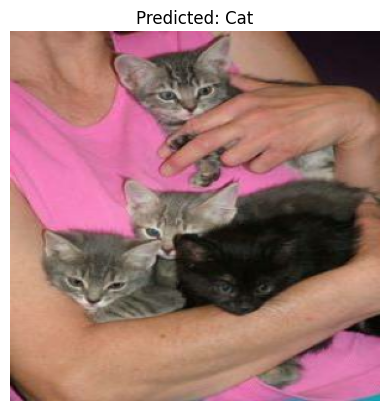

1/1 [==============================] - 0s 179ms/step


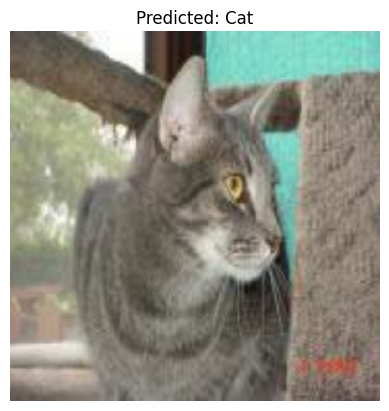

1/1 [==============================] - 0s 165ms/step


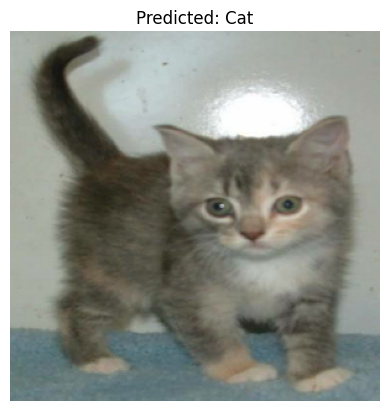

1/1 [==============================] - 0s 161ms/step


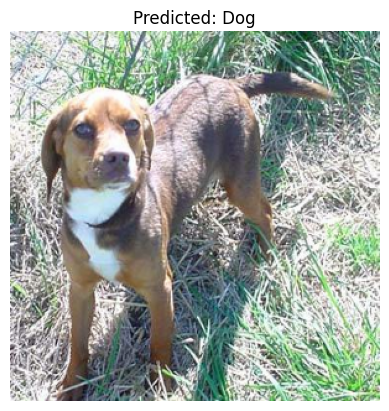

In [15]:
for images, labels in val_ds.take(4):
    pred = model.predict(images[:1])
    plt.imshow(tf.cast(images[0]*127.5+127.5, tf.uint8))
    plt.title(f"Predicted: {'Dog' if pred[0][0] > 0.5 else 'Cat'}")
    plt.axis('off')
    plt.show()
 